In [19]:
# If the below code doesn't work uncomment this and run (this adds the parent directory to the path)
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from BasicSetupUtilities.MetaDataBuilder import CountryMetaDataFile
from DataIOUtilities.DataLib import DataLib, DatastreamPulls
import pandas as pd
import numpy as np
from scipy import stats

plt.style.use("seaborn-darkgrid")
dl = DataLib("SignalData")

In [29]:
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

# Exploration

In [2]:
# Pull all the necessary dataframes to avoid duplicate code. 
bri = dl.pull("BondRetIdx/LocalFX")
lr = dl.pull('LongRates')
sr = dl.pull('ShortRates')

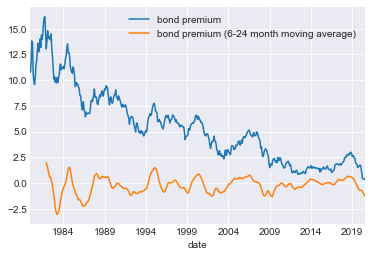

In [3]:
# Get bond premium. 
height = (lr + sr) / 2

# Get an oscillator: an 24-6 rolling average. 
# This oscillator better captures local changes. 
height_sma_diff = height.rolling(6).mean() - height.rolling(24).mean()

# Plot the height curve and the 6-24 difference.
height['USA'].plot(label='bond premium')
height_sma_diff['USA'].plot(label='bond premium (6-24 month moving average)')
plt.legend()

In [4]:
# Get the rolling average of the monthly change in bond returns. 
bri_chg = bri.resample('M').mean().pct_change()
bri_chg_sma = bri_chg.rolling(24).mean()

/Users/oliverschwartz/.local/share/virtualenvs/Intership2020-KRb_1UV-/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/oliverschwartz/.local/share/virtualenvs/Intership2020-KRb_1UV-/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/oliverschwartz/.local/share/virtualenvs/Intership2020-KRb_1UV-/lib/python3.6/site-packages/pandas/plotting/_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec()

/Users/oliverschwartz/.local/share/virtualenvs/Intership2020-KRb_1UV-/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/oliverschwartz/.local/share/virtualenvs/Intership2020-KRb_1UV-/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/oliverschwartz/.local/share/virtualenvs/Intership2020-KRb_1UV-/lib/python3.6/site-packages/pandas/plotting/_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec()

/Users/oliverschwartz/.local/share/virtualenvs/Intership2020-KRb_1UV-/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/oliverschwartz/.local/share/virtualenvs/Intership2020-KRb_1UV-/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/oliverschwartz/.local/share/virtualenvs/Intership2020-KRb_1UV-/lib/python3.6/site-packages/pandas/plotting/_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec()

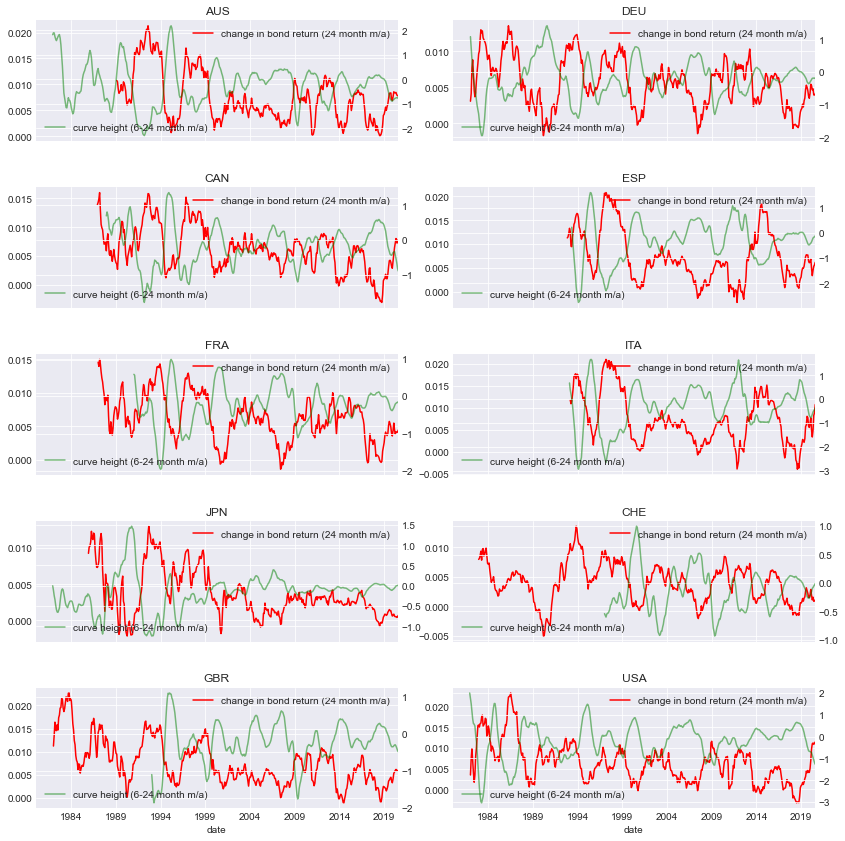

In [5]:
# For every country, plot the bond returns alongside our oscillator.
fig, axs = plt.subplots(5, 2, figsize=(12, 12))
fig.tight_layout(pad=3)

for i, country in enumerate(bri.columns.values):
    ax1 = axs[i//2][i%2]
    ax2 = ax1.twinx()
    bri_chg_sma[country].plot(ax=ax1, color='red', title=country, label='change in bond return (24 month m/a)')
    height_sma_diff[country].plot(ax=ax2, color='green', label='curve height (6-24 month m/a)', alpha=0.5)
    ax1.legend(loc=1)
    ax2.legend(loc=3)

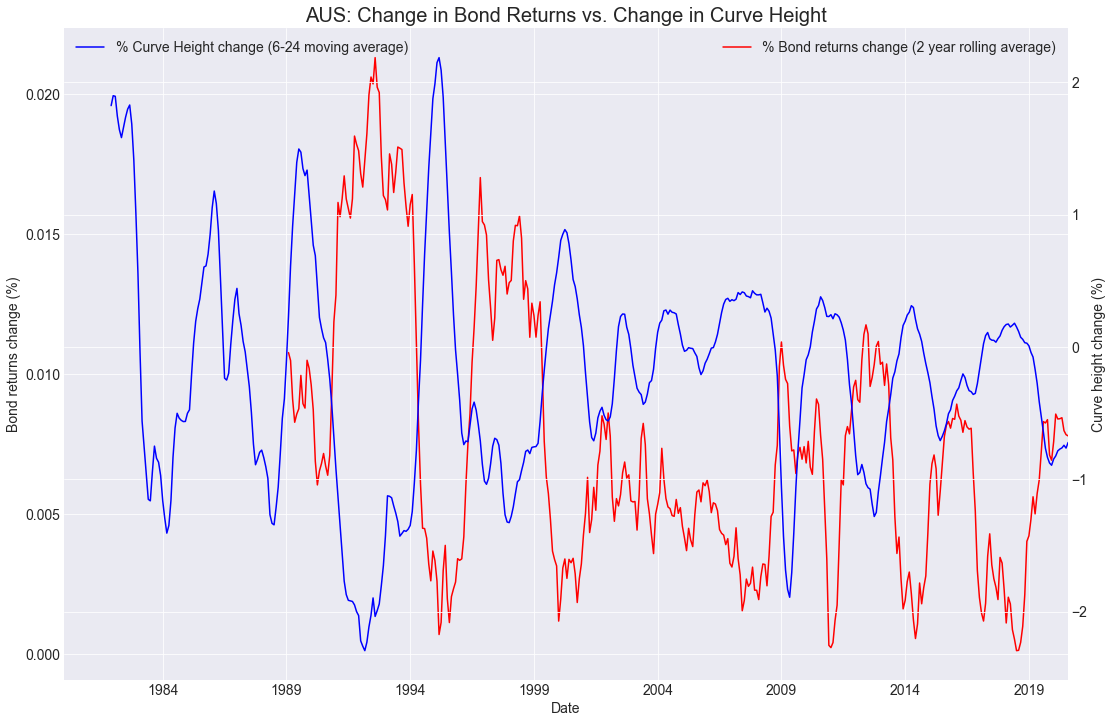

pearson correlation: -0.747829942372617


In [25]:
fig, ax = plt.subplots(figsize=(18, 12))
ax.set_ylabel("Bond returns change (%)", fontsize=14)
bri_chg_sma['AUS'].plot(color='red', label='% Bond returns change (2 year rolling average)', fontsize=14)
plt.legend(loc=1, prop={'size': 14})
axtwin = ax.twinx()
axtwin.set_ylabel("Curve height change (%)", fontsize=14)
ax.set_xlabel("Date", fontsize=14)
ax = height_sma_diff['AUS'].plot(ax=axtwin, color='blue', label='% Curve Height change (6-24 moving average)', title="AUS: Change in Bond Returns vs. Change in Curve Height", fontsize=14)
ax.title.set_size(20)
plt.legend(loc=2, prop={'size': 14})
plt.show()

print('pearson correlation:', bri_chg_sma['AUS'].corr(height_sma_diff['AUS']))

<AxesSubplot:xlabel='country'>

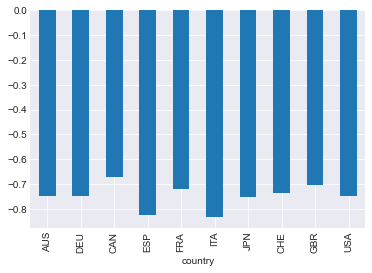

In [7]:
# Get the correlation between our oscillator and bond returns. 
correlation = height_sma_diff.corrwith(bri_chg_sma)
correlation.plot.bar()

# Building the indicator

In [8]:
# Get bond premium. 
height = (lr + sr) / 2

# Get the mean across all countries of the 12-month rolling average of monthly change.
height_average = height.rolling(12).mean().mean(axis=1)

# Subtract this mean from the monthly change.
height_subglobal = height.subtract(height_average, axis=0)

# Turn the change into a zscore. 
sma = height_subglobal.rolling(12).mean()
std = height_subglobal.rolling(12).std()
zscore = (sma - height_subglobal) / std

In [9]:
# Save the indicator. 
dl.write_data('height_zscore', zscore)

In [10]:
for country in bri.columns.values: 
    print('{} zscore/return corr:'.format(country), zscore[country].corr(bri_chg_sma[country]))

AUS zscore/return corr: 0.19026569527425735
DEU zscore/return corr: 0.04688742850169895
CAN zscore/return corr: 0.14241236780800384
ESP zscore/return corr: 0.2936804352914265
FRA zscore/return corr: -0.02602084570442086
ITA zscore/return corr: 0.3438753880300495
JPN zscore/return corr: 0.07928013744115583
CHE zscore/return corr: -0.1772621931327247
GBR zscore/return corr: 0.12169670749590555
USA zscore/return corr: 0.23398884427002428


# Return stream

In [11]:
zscore.index

PeriodIndex(['1980-01', '1980-02', '1980-03', '1980-04', '1980-05', '1980-06',
             '1980-07', '1980-08', '1980-09', '1980-10',
             ...
             '2019-11', '2019-12', '2020-01', '2020-02', '2020-03', '2020-04',
             '2020-05', '2020-06', '2020-07', '2020-08'],
            dtype='period[M]', name='date', length=488, freq='M')

<AxesSubplot:xlabel='date'>

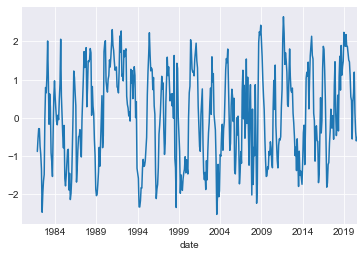

In [12]:
zscore['AUS'].plot()

In [13]:
# Clip the signal to between -2 and 2, then scale to [-1,1]
signal = (1 * zscore).clip(upper=2, lower=-2) / 2

/Users/oliverschwartz/.local/share/virtualenvs/Intership2020-KRb_1UV-/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/oliverschwartz/.local/share/virtualenvs/Intership2020-KRb_1UV-/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/oliverschwartz/.local/share/virtualenvs/Intership2020-KRb_1UV-/lib/python3.6/site-packages/pandas/plotting/_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec()

/Users/oliverschwartz/.local/share/virtualenvs/Intership2020-KRb_1UV-/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/oliverschwartz/.local/share/virtualenvs/Intership2020-KRb_1UV-/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/oliverschwartz/.local/share/virtualenvs/Intership2020-KRb_1UV-/lib/python3.6/site-packages/pandas/plotting/_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec()

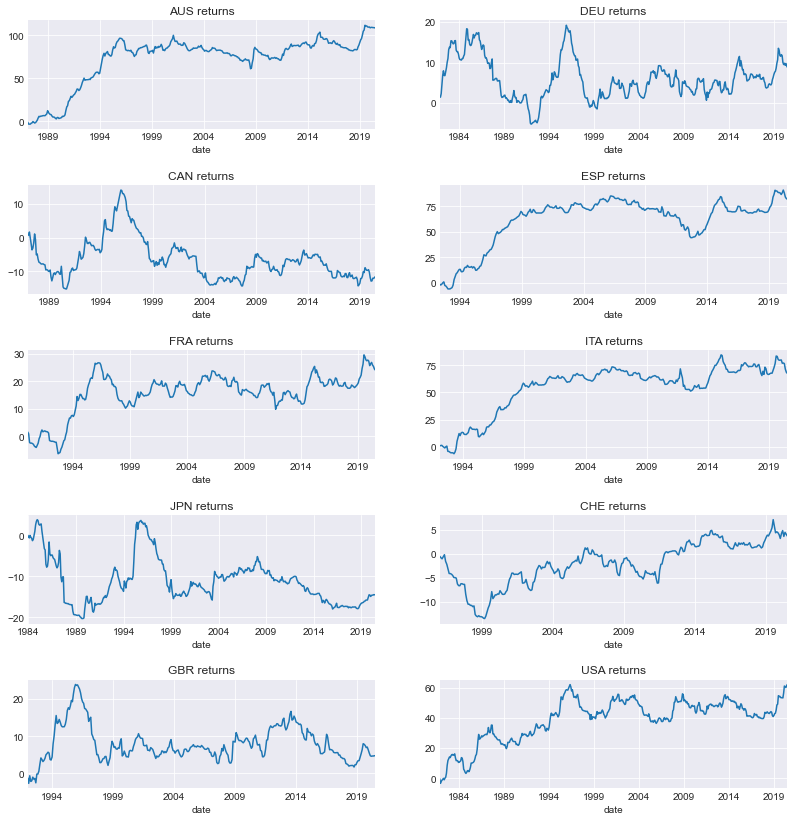

In [14]:
# Calculate the returns. 
returns = bri.resample('M').mean().pct_change().loc[signal.index].shift(-1)
returns = (signal * returns)

# Plot the return stream for every country. 
fig, axs = plt.subplots(5, 2, figsize=(12, 12))
fig.tight_layout(pad=4)
for i, country in enumerate(bri.columns.values):
    ax = axs[i//2][i%2]

    cumul_returns = ((returns[country].dropna() + 1).cumprod() - 1) * 100
    cumul_returns.plot(ax=ax, title='{} returns'.format(country))

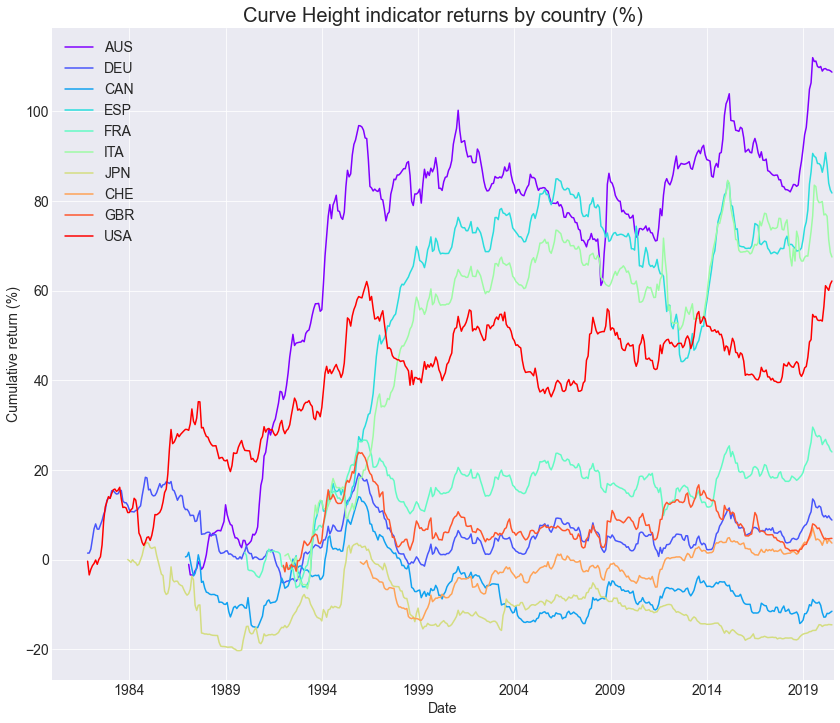

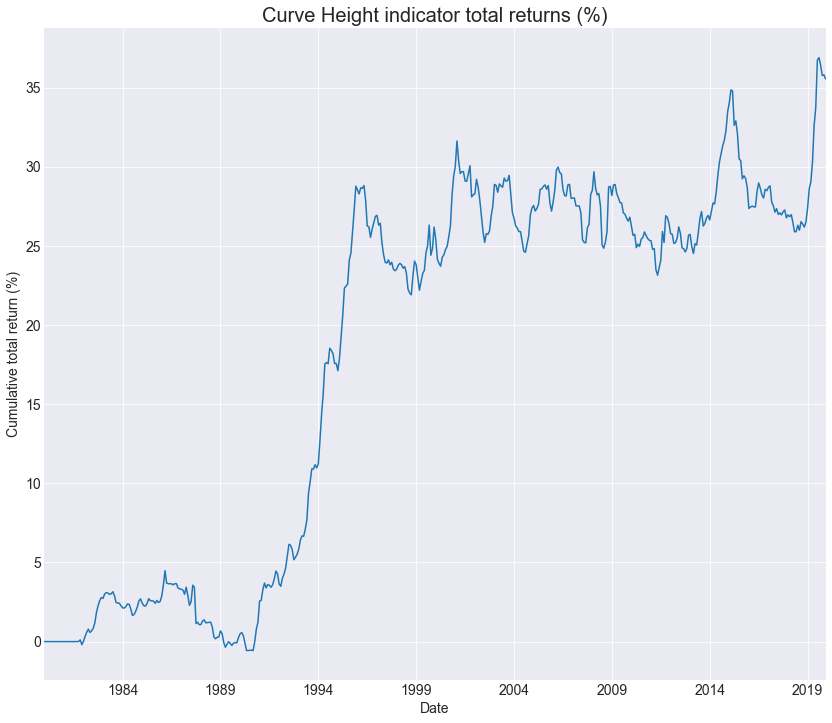

In [30]:
colors = pl.cm.jet(np.linspace(0,0.8,10))

# Plot all on same axis.
cumul_returns = ((returns + 1).cumprod() - 1) * 100
ax = cumul_returns.plot(title="Curve Height indicator returns by country (%)", figsize=(14,12), fontsize=14, cmap='rainbow')
ax.set_ylabel("Cumulative return (%)", fontsize=14)
ax.set_xlabel("Date", fontsize=14)
ax.title.set_size(20)
plt.legend(prop={'size': 14})
plt.show()

# Plot the sum. 
cumul_returns = cumul_returns[cumul_returns.index < '2020-01-01']
ax = (cumul_returns * 0.1).sum(axis=1).plot(title="Curve Height indicator total returns (%)", figsize=(14, 12), fontsize=14)
ax.set_ylabel("Cumulative total return (%)", fontsize=14)
ax.set_xlabel("Date", fontsize=14)
ax.title.set_size(20)